### Machine Learning (C24), Spring 2024, Project Group F
-----
# Resolve Outliers
In this notebook, we explore the output from [01_data_clean_join.ipynb](./01_data_clean_join.ipynb) to identify, analyze, fix (including verify fix) **outliers** that suggest data errors. Then **df_clean.csv** is written out for subsequent steps in data preparation including input into [03_data_explore.ipynb](./03_data_explore.ipynb).

Summary of outliers resolved:
1. Energy: `'generation*'` zeros spikes ➡️ forward filled
2. Weather: `'pressure_Barcelona'`, `'wind_speed_Valencia'` outside of even extreme Earth range ➡️ forward filled

In [1]:
# Import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Read the joined energy + weather dataset
df = pd.read_csv('./Data/df_final_new.csv', index_col='time', parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

In [4]:
# Quick data cleaning sanity check
# Resolved in 01_data_clean_join.ipynb
df.isnull().sum().sum() # 0 -> no missing data

0

In [5]:
df.index.duplicated().any() # False -> no duplicated indices

False

## Energy dataset
Observe, analyze, and fix for energy dataset outliers:
- **Previously:**`'generation*'` as y variables
- **Currently:** `'price*'` as y variables

### Energy dataset - generation

In [6]:
# Quick check of numerical outliers for 'generation*
generation_cols = [col for col in df.columns if 'generation' in col]
df[generation_cols].describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore
count,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000
mean,383.527281,448.102307,5622.761872,4256.511052,298.353241,475.520635,972.203018,2605.578506,6263.430535,60.226890,85.635464,1432.923305,269.425516,5465.077551
std,85.348023,354.630124,2201.642919,1962.052349,52.504793,792.310956,400.731568,1835.130371,840.245127,20.239084,14.077015,1680.030748,50.214685,3213.869444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,74.000000,71.000000,240.000000,2933.000000
50%,367.000000,509.000000,4970.000000,4474.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.000000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7401.000000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000


**Observations:** Eyeballing the min vs. mean/50% vs. max, these issues warrant further analysis:
- HIGH outliers: `'generation fossil gas'` and `'generation hydro pumped storage consumption'`
- LOW outliers: all `'generation*'` variables have zero generation times and potential low outliers

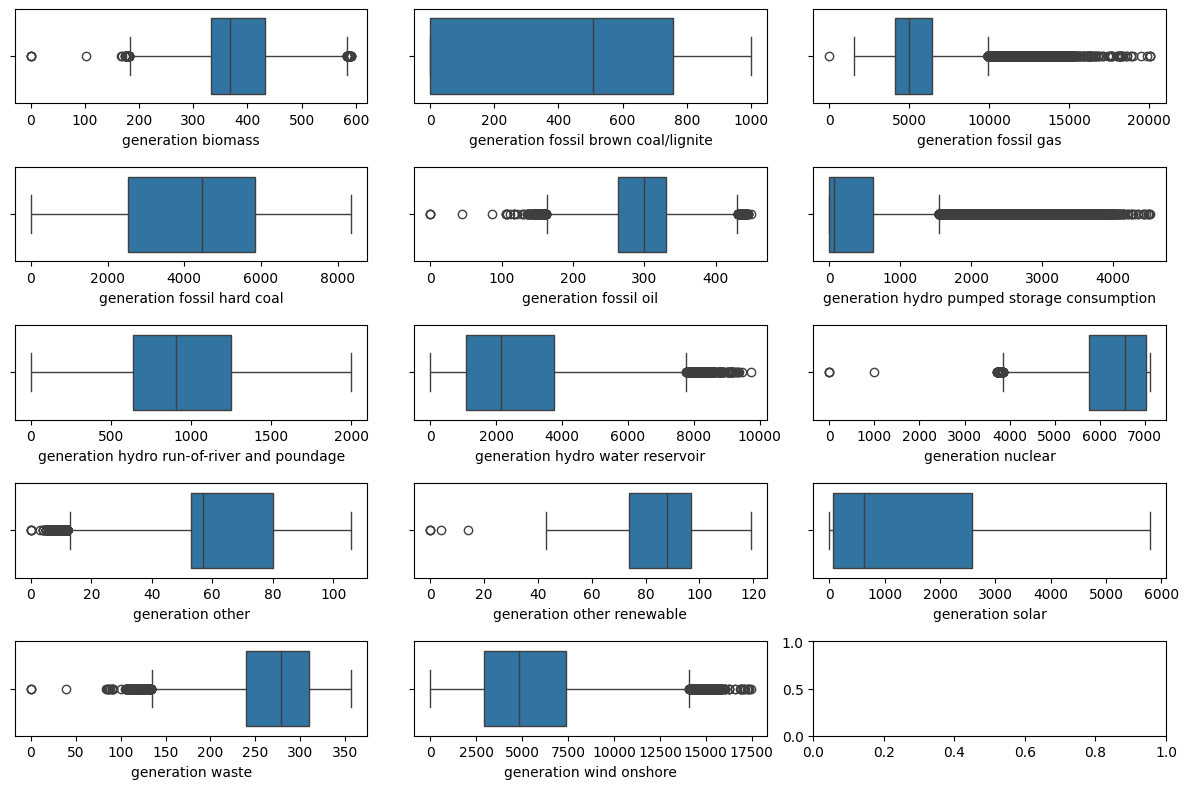

In [7]:
# Visualize 'generation*' for outliers
fig, axes = plt.subplots(5, 3, figsize=(12, 8))
axes = axes.flatten() #flattern for easy iteration
for i, col in enumerate(generation_cols): #loop through variables
    sns.boxplot(x=df[col], ax=axes[i])
plt.tight_layout()
plt.show()

**Analysis:**
- `generation fossil gas` and `generation hydro pumped storage consumption` high outliers seem consistent with its distribution
- `generation*` low outliers do exist including at zero (down times for system?) ➡️ visualize vs. time

In [8]:
# Check when multiple generation systems were zero
df[(df['generation nuclear'] == 0) & (df['generation biomass'] == 0)]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,weather_broken clouds_Barcelona,weather_few clouds_Barcelona,weather_light rain_Barcelona,weather_others_Barcelona,weather_scattered clouds_Barcelona,weather_sky is clear_Barcelona,temp_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,weather_broken clouds_Bilbao,weather_few clouds_Bilbao,weather_light rain_Bilbao,weather_others_Bilbao,weather_scattered clouds_Bilbao,weather_sky is clear_Bilbao,temp_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,weather_broken clouds_Madrid,weather_few clouds_Madrid,weather_light rain_Madrid,weather_others_Madrid,weather_scattered clouds_Madrid,weather_sky is clear_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,weather_broken clouds_Seville,weather_few clouds_Seville,weather_light rain_Seville,weather_others_Seville,weather_scattered clouds_Seville,weather_sky is clear_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,weather_broken clouds_Valencia,weather_few clouds_Valencia,weather_light rain_Valencia,weather_others_Valencia,weather_scattered clouds_Valencia,weather_sky is clear_Valencia,hour,weekday,month,price_prev_1,price_prev_2,price_prev_3
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-12 20:00:00+00:00,0.0,0.0,6899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,8536.0,36671.0,36562.0,69.48,67.66,285.15,1011.0,81.0,1.0,290.0,0.0,0.0,0,0,0,0,0,1,286.04,1022.0,93.0,7.0,310.0,0.0,75.0,1,0,0,0,0,0,286.49,1020.0,47.0,4.0,340.0,0.0,0.0,0,0,0,0,0,1,288.94,1020.0,67.0,2.0,210.0,0.0,0.0,0,0,0,0,0,1,293.15,1015.0,28.0,4.0,340.0,0.0,0.0,0,0,0,0,0,1,20.0,6.0,11.0,71.26,72.18,69.72
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325.0,7561.0,33805.0,34172.0,60.53,66.17,285.65,1018.0,35.0,6.0,33.0,0.0,0.0,0,0,0,0,0,1,281.93,1028.0,66.0,1.0,150.0,0.0,20.0,0,1,0,0,0,0,282.52,1020.0,37.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,285.94,1020.0,33.0,6.0,50.0,0.0,0.0,0,0,0,0,0,1,289.15,1019.0,19.0,1.0,277.0,0.0,0.0,0,0,0,0,0,1,11.0,1.0,11.0,65.88,65.88,68.87
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,5679.0,35592.0,34998.0,68.05,75.45,284.15,1019.0,53.0,3.0,46.0,0.0,0.0,0,0,0,0,0,1,279.49,1026.0,70.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,285.20,1018.0,37.0,1.0,280.0,0.0,0.0,0,0,0,0,0,1,289.15,1017.0,53.0,2.0,100.0,0.0,0.0,0,0,0,0,0,1,286.15,1019.0,35.0,1.0,150.0,0.0,0.0,0,0,0,0,0,1,18.0,1.0,11.0,74.18,69.21,68.61


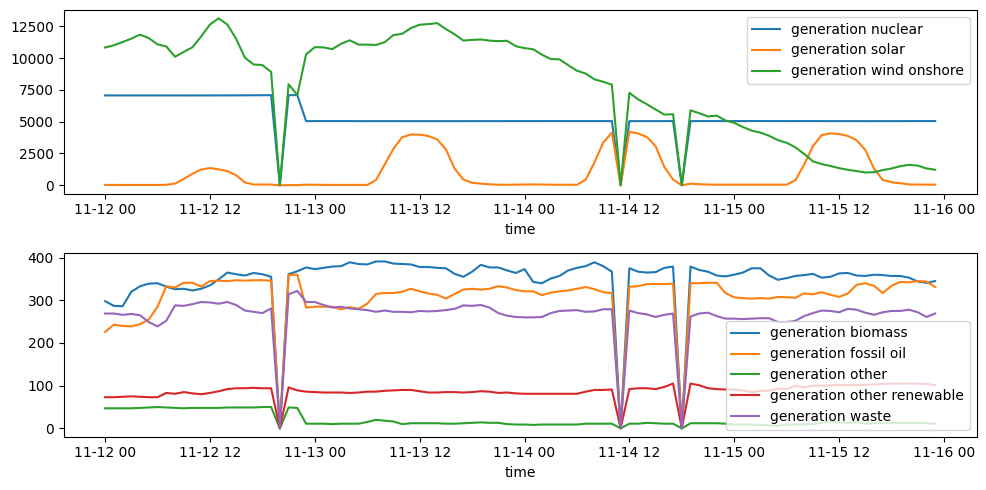

In [9]:
# Filter data within the three days above
df_time = df.loc['2017-11-12':'2017-11-15']

# Plot variable over the specified time range
gen_vars = [['generation nuclear', 'generation solar', 'generation wind onshore'],
            ['generation biomass', 'generation fossil oil', 'generation other', 'generation other renewable', 'generation waste']]
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
for i, ax in enumerate(axes):
    for gen_var in gen_vars[i]:
        sns.lineplot(data=df_time, x=df_time.index, y=gen_var, label=gen_var, ax=ax)
    ax.set_ylabel('') #else uses first y variable
    
plt.tight_layout()
plt.show()

In [10]:
# Check how often each 'generation*' is zero
df[generation_cols].eq(0).sum().sort_values(ascending=False)

generation hydro pumped storage consumption    12615
generation fossil brown coal/lignite           10524
generation biomass                                 4
generation other                                   4
generation fossil hard coal                        3
generation fossil oil                              3
generation hydro run-of-river and poundage         3
generation hydro water reservoir                   3
generation nuclear                                 3
generation other renewable                         3
generation solar                                   3
generation waste                                   3
generation wind onshore                            3
generation fossil gas                              1
dtype: int64

**Fix and verify:**
- Since most of these generation systems suddenly spiked down to 0 and then back up to previous levels strongly suggests that these are data ERRORS. Set to NA (excluding the two variables with many zero values) and then **forward fill with previous values**.

In [11]:
# Replace outliers in 'generation*' with NaNs
df_gen0_counts = df[generation_cols].eq(0).sum()
generation0_cols = df_gen0_counts[df_gen0_counts < 10].index
for col in generation0_cols:
    df.loc[df[col] == 0, col] = np.nan

In [12]:
# Forward fill NAs
df.isnull().sum().sum() # 36 -> from above
#df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
df2 = df.ffill()
df2.isnull().sum().sum() # 0

0

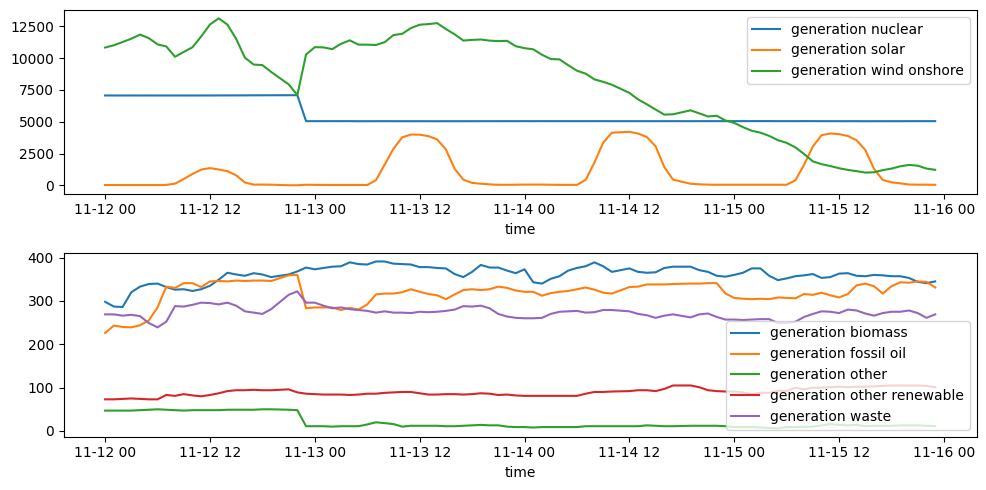

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
for i, ax in enumerate(axes):
    for gen_var in gen_vars[i]:
        sns.lineplot(data=df_time, x=df_time.index, y=gen_var, label=gen_var, ax=ax)
    ax.set_ylabel('')
    
plt.tight_layout()
plt.show()

### Energy dataset - price

In [14]:
# Quick check of numerical outliers for '*price*
price_cols = [col for col in df.columns if 'price' in col]
df2[price_cols].describe()

,price day ahead,price actual,price_prev_1,price_prev_2,price_prev_3
count,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000
mean,49.874458,57.883419,57.883265,57.883124,57.882870
std,14.619516,14.204541,14.204440,14.204345,14.204131
min,2.060000,9.330000,9.330000,9.330000,9.330000
25%,41.490000,49.340000,49.340000,49.340000,49.340000
50%,50.530000,58.020000,58.020000,58.020000,58.020000
75%,60.530000,68.010000,68.010000,68.010000,68.010000
max,101.990000,116.800000,116.800000,116.800000,116.800000


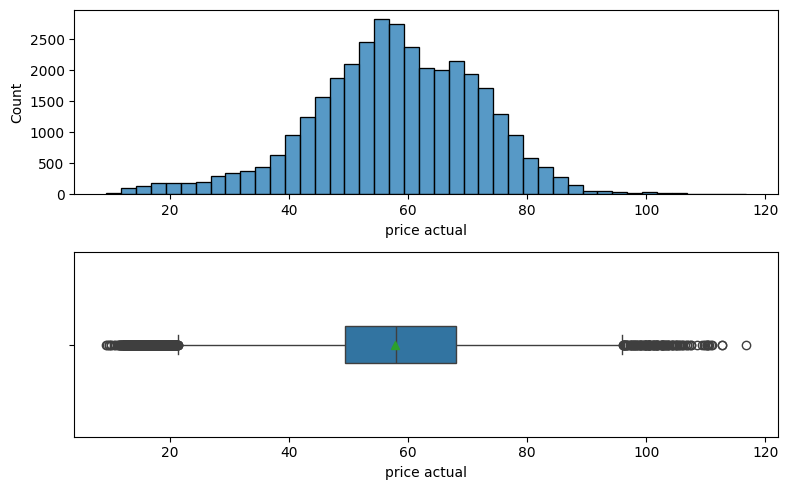

In [15]:
# Plot `price actual` 
price_col = 'price actual'
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
sns.histplot(data=df2, x=price_col, binwidth=2.5, ax=axes[0])
sns.boxplot(data=df2, x=price_col, width=0.2, showmeans=True, ax=axes[1])

plt.tight_layout()
plt.show()

**Observations:**
- Distribution (non-time-series) looks normal and not skewed
- Slightly bimodal around 55 and 67.5 EUR/MWh
- Outliers exist but they don't seem like data errors ➡️ KEEPING ALL

## Weather dataset
Observe, analyze, and fix for weather dataset outliers.

In [16]:
# Quick check of numerical outliers from weather datasets
df2[df2.columns[20:85]].describe()

,temp_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,weather_broken clouds_Barcelona,weather_few clouds_Barcelona,weather_light rain_Barcelona,weather_others_Barcelona,weather_scattered clouds_Barcelona,weather_sky is clear_Barcelona,temp_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,weather_broken clouds_Bilbao,weather_few clouds_Bilbao,weather_light rain_Bilbao,weather_others_Bilbao,weather_scattered clouds_Bilbao,weather_sky is clear_Bilbao,temp_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,weather_broken clouds_Madrid,weather_few clouds_Madrid,weather_light rain_Madrid,weather_others_Madrid,weather_scattered clouds_Madrid,weather_sky is clear_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,weather_broken clouds_Seville,weather_few clouds_Seville,weather_light rain_Seville,weather_others_Seville,weather_scattered clouds_Seville,weather_sky is clear_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,weather_broken clouds_Valencia,weather_few clouds_Valencia,weather_light rain_Valencia,weather_others_Valencia,weather_scattered clouds_Valencia,weather_sky is clear_Valencia
count,35061.000000,3.506100e+04,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000,35061.000000
mean,289.867893,1.287233e+03,73.828470,2.782379,187.675622,0.108497,22.716637,0.075839,0.270985,0.053535,0.081173,0.097630,0.420838,286.444896,1017.482302,78.729443,1.958444,159.903254,0.119167,43.442429,0.211745,0.127720,0.141496,0.159180,0.118907,0.240951,288.278956,1011.784604,58.724937,2.433929,173.353327,0.043305,20.663101,0.082371,0.120019,0.038675,0.091441,0.087105,0.580388,293.168215,1018.535239,63.779670,2.482787,151.896837,0.041140,14.166282,0.047945,0.087191,0.033770,0.101994,0.056730,0.672371,290.785714,1015.980634,65.092924,2.692650,160.811215,0.034461,20.742249,0.079718,0.309603,0.033627,0.039788,0.094350,0.442914
std,6.723467,1.346360e+04,17.719913,1.995785,108.562170,0.667799,27.328804,0.264745,0.444475,0.225102,0.273104,0.296818,0.493701,6.802025,9.819640,16.707370,1.870237,122.864317,0.369954,33.738253,0.408551,0.333783,0.348538,0.365849,0.323684,0.427667,9.325303,20.237311,24.884350,1.973080,121.945193,0.198326,29.657135,0.274933,0.324989,0.192823,0.288239,0.281993,0.493502,8.080796,6.865171,22.882265,1.868547,104.326402,0.215367,26.170488,0.213653,0.282119,0.180638,0.302644,0.231329,0.469355,7.232375,11.937391,19.678796,2.582998,120.413197,0.263605,25.604393,0.270860,0.462337,0.180270,0.195463,0.292319,0.496738
min,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,266.850000,961.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,264.132000,927.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,271.050000,986.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

**Observations:** Eyeballing the min vs. mean/50% vs. max these issues warrant further analysis:
- HIGH: `'pressure_Barcelona'`, `'wind_speed_Valencia'`
- high: `'rain_1h_Barcelona'`, `'rain_1h_Valencia'`
- zero: `pressure_Barcelona`

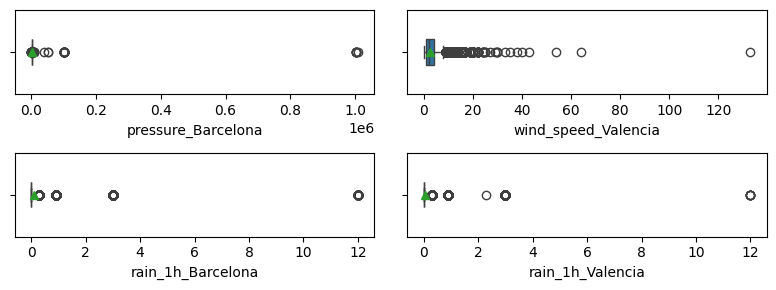

In [17]:
# Prep list of variables to visualize
outlier_cols = ['pressure_Barcelona', 'wind_speed_Valencia', 'rain_1h_Barcelona', 'rain_1h_Valencia']

# Check boxplot for very high outliers
fig, axes = plt.subplots(2, 2, figsize=(8, 3))
axes = axes.flatten() #flattern for easy iteration
for i, col in enumerate(outlier_cols):
    sns.boxplot(x=df2[col], width=0.3, showmeans=True, ax=axes[i])
plt.tight_layout()
plt.show()

In [18]:
# Check value counts for highest outliers
outlier_counts = list()
for col in outlier_cols:
    outlier_counts.append(df2[col].value_counts().sort_index(ascending=False).iloc[0])  
pd.DataFrame(outlier_counts, index=outlier_cols, columns=['highest outlier count'])

,highest outlier count
pressure_Barcelona,1
wind_speed_Valencia,1
rain_1h_Barcelona,72
rain_1h_Valencia,6


**Analysis:** The high outliers for the top two must be data ERRORS based on Chat GPT prompts:
- Normal+extreme sea level pressure range is from 900-1050 hPA ➡️ DROP
- Extreme wind speed is around 45 m/s ➡️ DROP
- Rainfall rates of 25 mm/h are considered high ➡️ KEEP

**Fix and verify:**
- Set outlers to DROP to NA and then **forward fill with previous values**

In [19]:
# Replace outliers in weather dataset with NaNs
df2.loc[df2['pressure_Barcelona'] > 1100, 'pressure_Barcelona'] = np.nan
df2.loc[df2['pressure_Barcelona'] < 850, 'pressure_Barcelona'] = np.nan
df2.loc[df2['wind_speed_Valencia'] > 50, 'wind_speed_Valencia'] = np.nan

# Forward fill NAs
df2.isnull().sum().sum() # 51
df3 = df2.ffill()
df3.isnull().sum().sum() # 0

0

<Axes: xlabel='wind_speed_Valencia'>

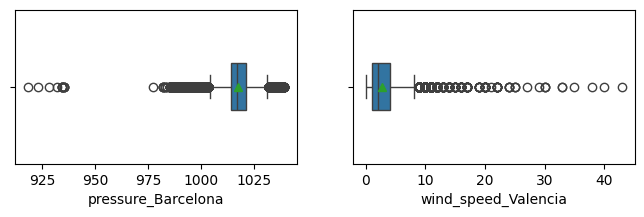

In [20]:
# Recheck boxplots
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
sns.boxplot(x=df3['pressure_Barcelona'], width=0.3, showmeans=True, ax=axes[0])
sns.boxplot(x=df3['wind_speed_Valencia'], width=0.3, showmeans=True, ax=axes[1])

## Write out to CSV

In [21]:
#df3.to_csv('./Data/df_clean.csv')
df3.shape #(35061, 91)

(35061, 91)